# 01 特征提取背景

在之前的Task2中，我们初步查看了数据集的信息，并通过音频的声波图和声谱图将声音可视化了。当我们拿到这些音频数据之后，接下来就需要进行特征提取（过滤掉背景噪音等不需要的信息）筛选出我们需要的信息了。

接下来我们将简要介绍以下特征，并详细学习MFCC特征提取知识：
- 过零率 （Zero Crossing Rate）
- 频谱质心 （Spectral Centroid）
- 声谱衰减 (Spectral Roll-off）
- 梅尔频率倒谱系数 （Mel-frequency cepstral coefficients ，MFCC）
- 色度频率 （Chroma Frequencies）



# 02 常见的音频特征提取

导包

In [ ]:
import numpy as np
import sklearn
import librosa
import librosa.display
import matplotlib.pyplot as plt

## 2.1 过零率

过零率（zero crossing rate）是一个信号符号变化的比率，即，在每帧中，语音信号从正变为负或从负变为正的次数。 这个特征已在语音识别和音乐信息检索领域得到广泛使用，通常对类似金属、摇滚等高冲击性的声音的具有更高的价值。

一般情况下，过零率越大，频率近似越高。


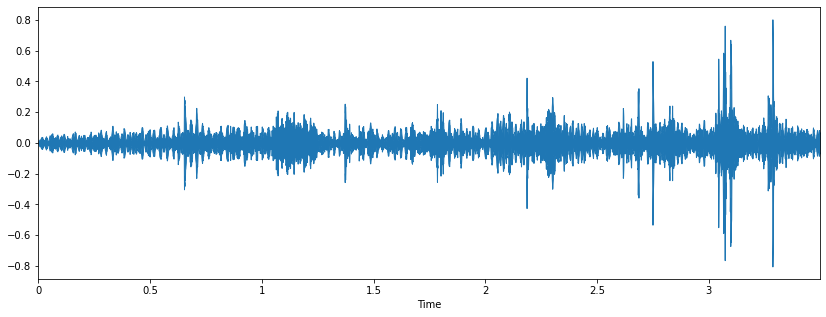

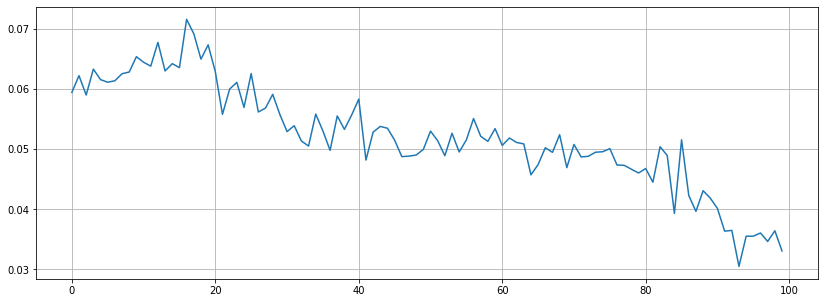

In [ ]:
x, sr = librosa.load('./clips_rd/aloe/aloe_10_01.wav')
#绘制声波信号
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)
# 放大
n0 = 9000
n1 = 9100
plt.figure(figsize=(14, 5))
plt.plot(x[n0:n1])
plt.grid()

可以看到该音频信号没有过零点，我们开源用librosa库进行验证，输出过零点个数：

In [ ]:
# 计算过零率
zero_crossings = librosa.zero_crossings(x[n0:n1], pad=False)
print(sum(zero_crossings))

0


## 2.2 频谱质心

谱质心(Spectral Centroid)是描述音色属性的重要物理参数之一，是频率成分的重心，是在一定频率范围内通过能量加权平均的频率，其单位是Hz。它是声音信号的频率分布和能量分布的重要信息。在主观感知领域，谱质心描述了声音的明亮度，具有阴暗、低沉品质的声音倾向有较多低频内容，谱质心相对较低，具有明亮、欢快品质的多数集中在高频，谱质心相对较高。该参数常用于对乐器声色的分析研究。

(151,)


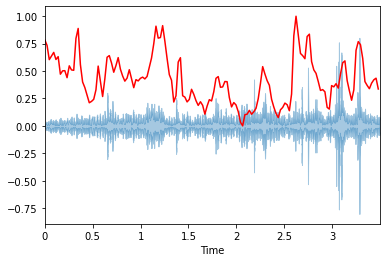

In [ ]:
spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]
print(spectral_centroids.shape)
# (2647,)
# 计算时间变量 
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)
# 归一化频谱质心
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)
#沿波形绘制频谱质心 
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r')

## 2.3 声谱衰减 

它是对声音信号形状（波形图）的一种衡量，表示低于总频谱能量的指定百分比的频率。

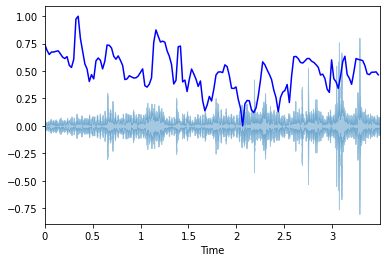

In [ ]:
spectral_rolloff = librosa.feature.spectral_rolloff(x+0.01, sr=sr)[0]
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='b')

## 2.4 色度频率

色度频率是音乐音频有趣且强大的表示，其中整个频谱被投影到12个区间，代表音乐八度音的12个不同的半音（或色度）

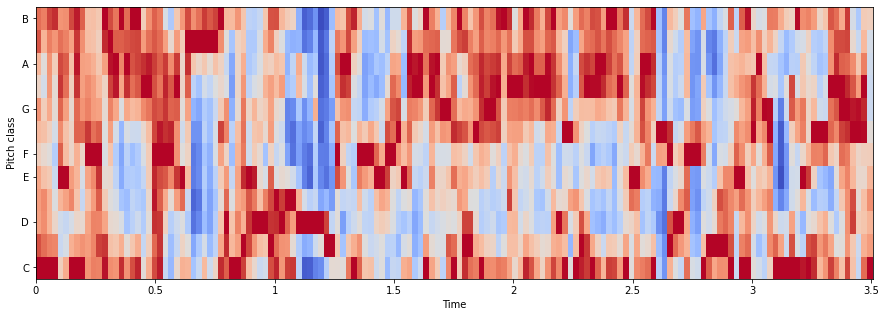

In [ ]:
hop_length = 512
chromagram = librosa.feature.chroma_stft(x, sr=sr, hop_length=hop_length)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')


# 03 MFCC特征提取


人的耳朵在接收信号的时候，不同的频率会引起耳蜗不同部位的震动。耳蜗就像一个频谱仪，自动在做特征提取并进行语音信号的处理。在语音识别领域中MFCC（Mel Frequency Cepstral Coefficents）特征提取是最常用的方法，也是本次音频分类任务中涉及到的特征提取方法。

具体来说，MFCC特征提取的步骤如下：
- 对语音信号进行分帧处理
- 用周期图(periodogram)法来进行功率谱(power spectrum)估计
- 对功率谱用Mel滤波器组进行滤波，计算每个滤波器里的能量
- 对每个滤波器的能量取log
- 进行离散余弦变换（DCT）变换
- 保留DCT的第2-13个系数，去掉其它

其中，前面两步是短时傅里叶变换，后面几步主要涉及梅尔频谱，接下来我们将分别学习这些知识。


## 3.1 短时傅里叶分析

声音信号本是一维时域信号（声音信号随时间变化），我们可以通过傅里叶变换将其转换到频域上,但这样又失去了时域信息，无法看出频率分布随时间的变化。短时傅里叶（STFT）就是为了解决这个问题而发明的常用手段。

所谓的短时傅里叶变换，即把一段长信号分帧、加窗，再对每一帧做快速傅里叶变换（FFT），最后把每一帧的结果沿另一个维度堆叠起来，得到类似于一幅图的二维信号形式，也就是我们task2中得到的声谱图。


![image](img/task3_1.png)

### 3.1.1 分帧

语音信号是不稳定的时变信号，但为了便于处理，我们假设在一个很短的时间内，如20-40ms内为一个稳定的系统，也就是1帧。但是我们不能简单平均分割语音，相邻的帧之间需要有一定的重合。我们通常以25ms为1帧，帧移为10ms，因此1秒的信号会有10帧。

### 3.1.2 对每帧信号进行DFT

我们可以使用离散傅里叶变换(DFT)把每一帧信号变换到时域，公式是：

![image](img/task3_2.png)

其中s(n)表示时域信号；si(n)是第i帧的数据，其中n的范围是1-400；当我们介绍DFT的时候，Si(k)表示的是第i帧的第k个复系数；Pi(k)是第i帧的功率谱。h(n)是一个N点的窗函数(比如Hamming窗)，K是DFT的长度。有了Si(k)我们就可以估计功率谱：

![image](img/task3_3.png)

这样，我们就得到了周期图的功率谱估计，即声谱图。以之前task2的芦荟音频为例，它的横坐标是帧下标，纵坐标是不同频率或者叫能量，图中颜色越深(比如红色)，对应频率的能量越大。

![image](img/task3_4.png)

我们可以利用 librosa库做短时傅立叶变换（STFT），通过STFT能够返回一个复数矩阵，使得：

- 复数的实部：np.abs(D(f,t))为频率的振幅
- 复数的虚部：np.angle(D(f,t))为频率的相位


In [ ]:
# STFT
y, sr = librosa.load('./clips_rd/aloe/aloe_10_01.wav')
S =librosa.stft(y, n_fft=2048, hop_length=None, win_length=None, window='hann', center=True, pad_mode='reflect')
'''
• y：音频时间序列
• n_fft：FFT窗口大小，n_fft=hop_length+overlapping
• hop_length：帧移，如果未指定，则默认win_length / 4
• win_length：每一帧音频都由window()加窗。窗长win_length，然后用零填充以匹配n_fft
 默认win_length=n_fft。
• window：字符串，元组，数字，函数 shape =（n_fft, )
 窗口（字符串，元组或数字）
 窗函数，例如scipy.signal.hanning
 长度为n_fft的向量或数组
• center：bool
 如果为True，则填充信号y，以使帧 D [:, t]以y [t * hop_length]为中心
 如果为False，则D [:, t]从y [t * hop_length]开始
• dtype：D的复数值类型。默认值为64-bit complex复数
• pad_mode：如果center = True，则在信号的边缘使用填充模式
 默认情况下，STFT使用reflection padding
'''
S = np.abs(S)
print(y.shape)
print(S.shape)

(77147,)
(1025, 151)


# 04 梅尔频谱和梅尔倒谱

声谱图往往是很大的一张图，且依旧包含了大量无用的信息，所以我们需要通过梅尔标度滤波器组（mel-scale filter banks）将其变为梅尔频谱。

## 4.1 梅尔尺度

梅尔尺度（Mel Scale）是建立从人类的听觉感知的频率——Pitch到声音实际频率直接的映射。频率的单位是赫兹（Hz），人耳能听到的频率范围是20-20000Hz，但人耳对Hz这种标度单位并不是线性感知关系，例如，若把音调频率从1000Hz提高到2000Hz，我们的耳朵只能觉察到频率似乎提高了一些而不是一倍。但是通过把频率转换成美尔尺度，我们的特征就能够更好的匹配人类的听觉感知效果。从频率到梅尔频率的转换公式如下：

![image](img/task3_5.png)

我们可以观察一下转换后的映射图，可以发现人耳对于低频声音的分辨率要高于高频的声音，因为赫兹到梅尔是log的关系，所以当频率较小时，mel随Hz变化较快；当频率很大时，mel的上升很缓慢，曲线的斜率很小。这说明了人耳对低频音调的感知较灵敏，在高频时人耳是很迟钝的，梅尔标度滤波器组启发于此。 

![image](img/task3_6.png)


## 4.2 梅尔滤波器

为了模拟人耳对声音的感知，人们发明的梅尔滤波器组。一组大约20-40(通常26)个三角滤波器组，它会对上一步得到的周期图的功率谱估计进行滤波。而且区间的频率越高，滤波器就越宽(但是如果把它变换到美尔尺度则是一样宽的)。为了计算方便，我们通常把26个滤波器用一个矩阵来表示，这个矩阵有26行，列数就是傅里叶变换的点数。

![image](img/task3_7.png)

计算过程如下图所示，最后我们会保留这26个滤波器的能量。图(a)是26个滤波器；图(b)是滤波后的信号；图(c)是其中的第8个滤波器，它只让某一频率范围的信号通过；图(d)通过它的信号的能量；图(e)是第20个滤波器；图(f)是通过它的信号的能量。

![image](img/task3_8.png)

## 4.3 梅尔倒谱

在梅尔频谱上做倒谱分析（取对数log，做离散余弦变换（DCT）变换）就得到了梅尔倒谱。

对上面得到的26个点的信号进行DCT，得到26个倒谱系数(Cepstral Coefficents)，最后我们保留2-13这12个数字，这12个数字就叫MFCC特征。对功率谱再做DCT的目的就是为了提取信号的包络。

(20, 151)


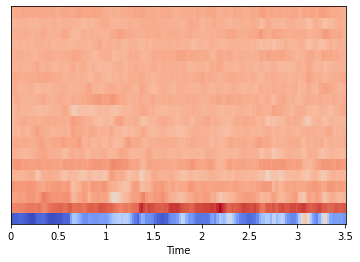

In [ ]:
#梅尔频率倒谱系数 MFCC
mfccs = librosa.feature.mfcc(x, sr)
print (mfccs.shape)
# (20, 151)
#Displaying  the MFCCs:
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

这里mfcc计算了超过151帧的20个MFCC。我们还可以进行特征缩放，使得每个系数维度具有零均值和单位方差：

[ 4.63810990e-09 -8.09202128e-09 -1.30261810e-08  9.86831861e-09
 -1.77629733e-08 -4.46047999e-08  4.38153336e-08 -1.87498062e-09
 -7.89465493e-10  3.90785431e-08 -1.18419825e-08 -2.05723598e-08
 -2.60893671e-08 -9.47358636e-09 -1.67761416e-09  1.77629733e-09
  3.29601839e-08  1.30261810e-08 -1.46051118e-08 -7.89465471e-09]
[1.0000002 0.9999999 1.0000004 1.0000001 1.        1.        1.
 0.9999997 1.0000004 0.9999996 1.0000008 0.9999998 0.9999999 0.9999999
 1.        0.9999998 0.9999995 0.9999998 0.9999999 1.0000001]


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


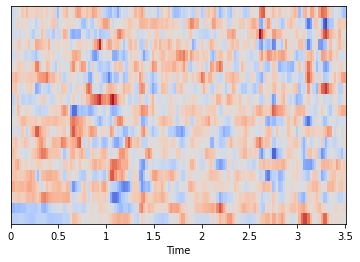

In [ ]:
# mfcc 特征缩放
mfccs = sklearn.preprocessing.scale(mfccs, axis=1)
print(mfccs.mean(axis=1))
print(mfccs.var(axis=1))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

# 05 本次任务中的特征提取

In [30]:

import os
import glob 
import numpy as np
from tensorflow.keras.utils import to_categorical 

feature = []
label = []
# 建立类别标签，不同类别对应不同的数字。
label_dict = {'aloe': 0, 'burger': 1, 'cabbage': 2,'candied':3, 'carrots': 4, 'chips':5,
                  'chocolate': 6, 'drinks': 7, 'fries': 8, 'grapes': 9, 'gummies': 10, 'ice-cream':11,
                  'jelly': 12, 'noodles': 13, 'pickles': 14, 'pizza': 15, 'ribs': 16, 'salmon':17,
                  'soup': 18, 'wings': 19}

建立提取音频特征的函数

In [25]:
def extract_features(parent_dir,sub_dirs,file_ext="*.wav"):
    for sub_dir in sub_dirs:
        for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)): # 遍历数据集的所有文件
           # segment_log_specgrams, segment_labels = [], []
            #sound_clip,sr = librosa.load(fn)
            #print(fn)
            label_name = fn.split('/')[3].split('_')[0]#这里的3长度指的是音频路径长度
            label.extend([label_dict[label_name]])
            X, sample_rate = librosa.load(fn,res_type='kaiser_fast')
            mels = np.mean(librosa.feature.melspectrogram(y=X,sr=sample_rate).T,axis=0) # 计算梅尔频谱(mel spectrogram),并把它作为特征
            feature.extend([mels])
    return [feature, label]

In [26]:
# 自己更改目录
parent_dir = './clips_rd'
save_dir = "./"
folds = sub_dirs = np.array(['aloe','burger','cabbage','candied_fruits',
                             'carrots','chips','chocolate','drinks','fries',
                            'grapes','gummies','ice-cream','jelly','noodles','pickles',
                            'pizza','ribs','salmon','soup','wings'])

# 获取特征feature以及类别的label
temp = extract_features(parent_dir,sub_dirs)
temp = np.array(temp)
data = temp.transpose()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()


In [27]:
# 获取特征
X_ = data[:, 0]
# 获取标签
Y = data[:, 1]
print('X的特征尺寸是：',X_.shape)
print('Y的特征尺寸是：',Y.shape)

X的特征尺寸是： (4,)
Y的特征尺寸是： (4,)


In [31]:
#X = np.empty([11140, 128])
#for i in range(11140):
#    X[i] = (X_[i])
X[i] = (X_[i])
X.shape

(11140, 128)

In [32]:
# 在Keras库中：to_categorical就是将类别向量转换为二进制（只有0和1）的矩阵类型表示
Y = to_categorical(Y)

In [33]:
# 最终数据
print(X.shape)
print(Y.shape)

(11140, 128)
(4, 2)


# 参考资料

[1. STFT和声谱图](https://blog.csdn.net/qq_28006327/article/details/59129110?utm_source=blogxgwz9)

[2. MFCC特征提取教程](http://fancyerii.github.io/books/mfcc/)

[3. librosa处理音频信号](42690?ops_request_misc=%257B%2522request%255Fid%2522%253A%2522161605127816780265442243%2522%252C%2522scm%2522%253A%252220140713.130102334..%2522%257D&request_id=161605127816780265442243&biz_id=0&utm_medium=distribute.pc_search_result.none-task-blog-2~all~sobaiduend~default-3-103542690.pc_search_result_no_baidu_js&utm_term=librosa+stft)
